# Análisis de Reservas de Hotel
## Introducción
Este proyecto tiene como objetivo realizar un análisis exhaustivo de un conjunto de datos de reservas de hotel. El análisis incluirá la exploración de datos (EDA), un análisis de negocio centrado en el impacto de las cancelaciones en los ingresos, y el entrenamiento y evaluación de modelos de clasificación para predecir el estado de las reservas.

## Diccionario de Datos
Los datos utilizados en este análisis provienen de Kaggle. A continuación, se detalla la fuente y una breve descripción de las columnas:


| Columna | Descripción | Tipo de Variable |
|---|---|---|
| `Booking_ID` | Identificador único de la reserva. | Numérica |
| `no_of_adults` | Número de adultos en la reserva. | Numérica Discreta |
| `no_of_children` | Número de niños en la reserva. | Numérica Discreta |
| `no_of_weekend_nights` | Número de noches de fin de semana reservadas. | Numérica Discreta |
| `no_of_week_nights` | Número de noches de entre semana reservadas. | Numérica Discreta |
| `type_of_meal_plan` | Tipo de plan de comidas. | Categórica |
| `required_car_parking_space` | Indica si se requiere espacio de estacionamiento. | Categórica Binaria |
| `room_type_reserved` | Tipo de habitación reservada. | Categórica |
| `lead_time` | Número de días entre la fecha de reserva y la fecha de llegada. | Numérica Discreta |
| `arrival_year` | Año de llegada. | Temporal |
| `arrival_month` | Mes de llegada. | Temporal |
| `arrival_date` | Día de llegada. | Temporal |
| `market_segment_type` | Tipo de segmento de mercado (ej. Online, Offline, etc.). | Categórica |
| `repeated_guest` | Indica si el huésped es recurrente. | Categórica Binaria |
| `no_of_previous_cancellations` | Número de cancelaciones previas del huésped. | Numérica Discreta |
| `no_of_previous_bookings_not_canceled` | Número de reservas previas no canceladas por el huésped. | Numérica Discreta |
| `avg_price_per_room` | Precio promedio por habitación por noche. | Numérica Continua |
| `no_of_special_requests` | Número de solicitudes especiales realizadas por el huésped. | Numérica Discreta |
| `booking_status` | Estado de la reserva. | Categórica Binaria |

- **Fuente de los datos**: [Hotel Reservations Classification Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download)

# EDA

## Variables numéricas

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv('data/Hotel Reservations.csv')

### Estadísticos básicos

In [21]:
import pandas as pd
import numpy as np

# Configuración para mostrar toda la tabla en una sola línea
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  # Ajusta este valor si necesitas más ancho
pd.set_option('display.colheader_justify', 'center')

# Seleccionar solo las columnas numéricas, excluyendo variables temporales
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
temporal_cols = ['arrival_year', 'arrival_month', 'arrival_date']
numerical_cols = [col for col in numerical_cols if col not in temporal_cols]

# Excluir 'Booking_ID' si es numérica pero no relevante para estadísticas descriptivas
if 'Booking_ID' in numerical_cols:
    numerical_cols.remove('Booking_ID')


print(df[numerical_cols].describe().T.to_string())

                                       count      mean        std     min   25%   50%    75%    max 
no_of_adults                          36275.0    1.844962   0.518715  0.0   2.0   2.00    2.0    4.0
no_of_children                        36275.0    0.105279   0.402648  0.0   0.0   0.00    0.0   10.0
no_of_weekend_nights                  36275.0    0.810724   0.870644  0.0   0.0   1.00    2.0    7.0
no_of_week_nights                     36275.0    2.204300   1.410905  0.0   1.0   2.00    3.0   17.0
required_car_parking_space            36275.0    0.030986   0.173281  0.0   0.0   0.00    0.0    1.0
lead_time                             36275.0   85.232557  85.930817  0.0  17.0  57.00  126.0  443.0
repeated_guest                        36275.0    0.025637   0.158053  0.0   0.0   0.00    0.0    1.0
no_of_previous_cancellations          36275.0    0.023349   0.368331  0.0   0.0   0.00    0.0   13.0
no_of_previous_bookings_not_canceled  36275.0    0.153411   1.754171  0.0   0.0   0.00    0

### Distribuciones

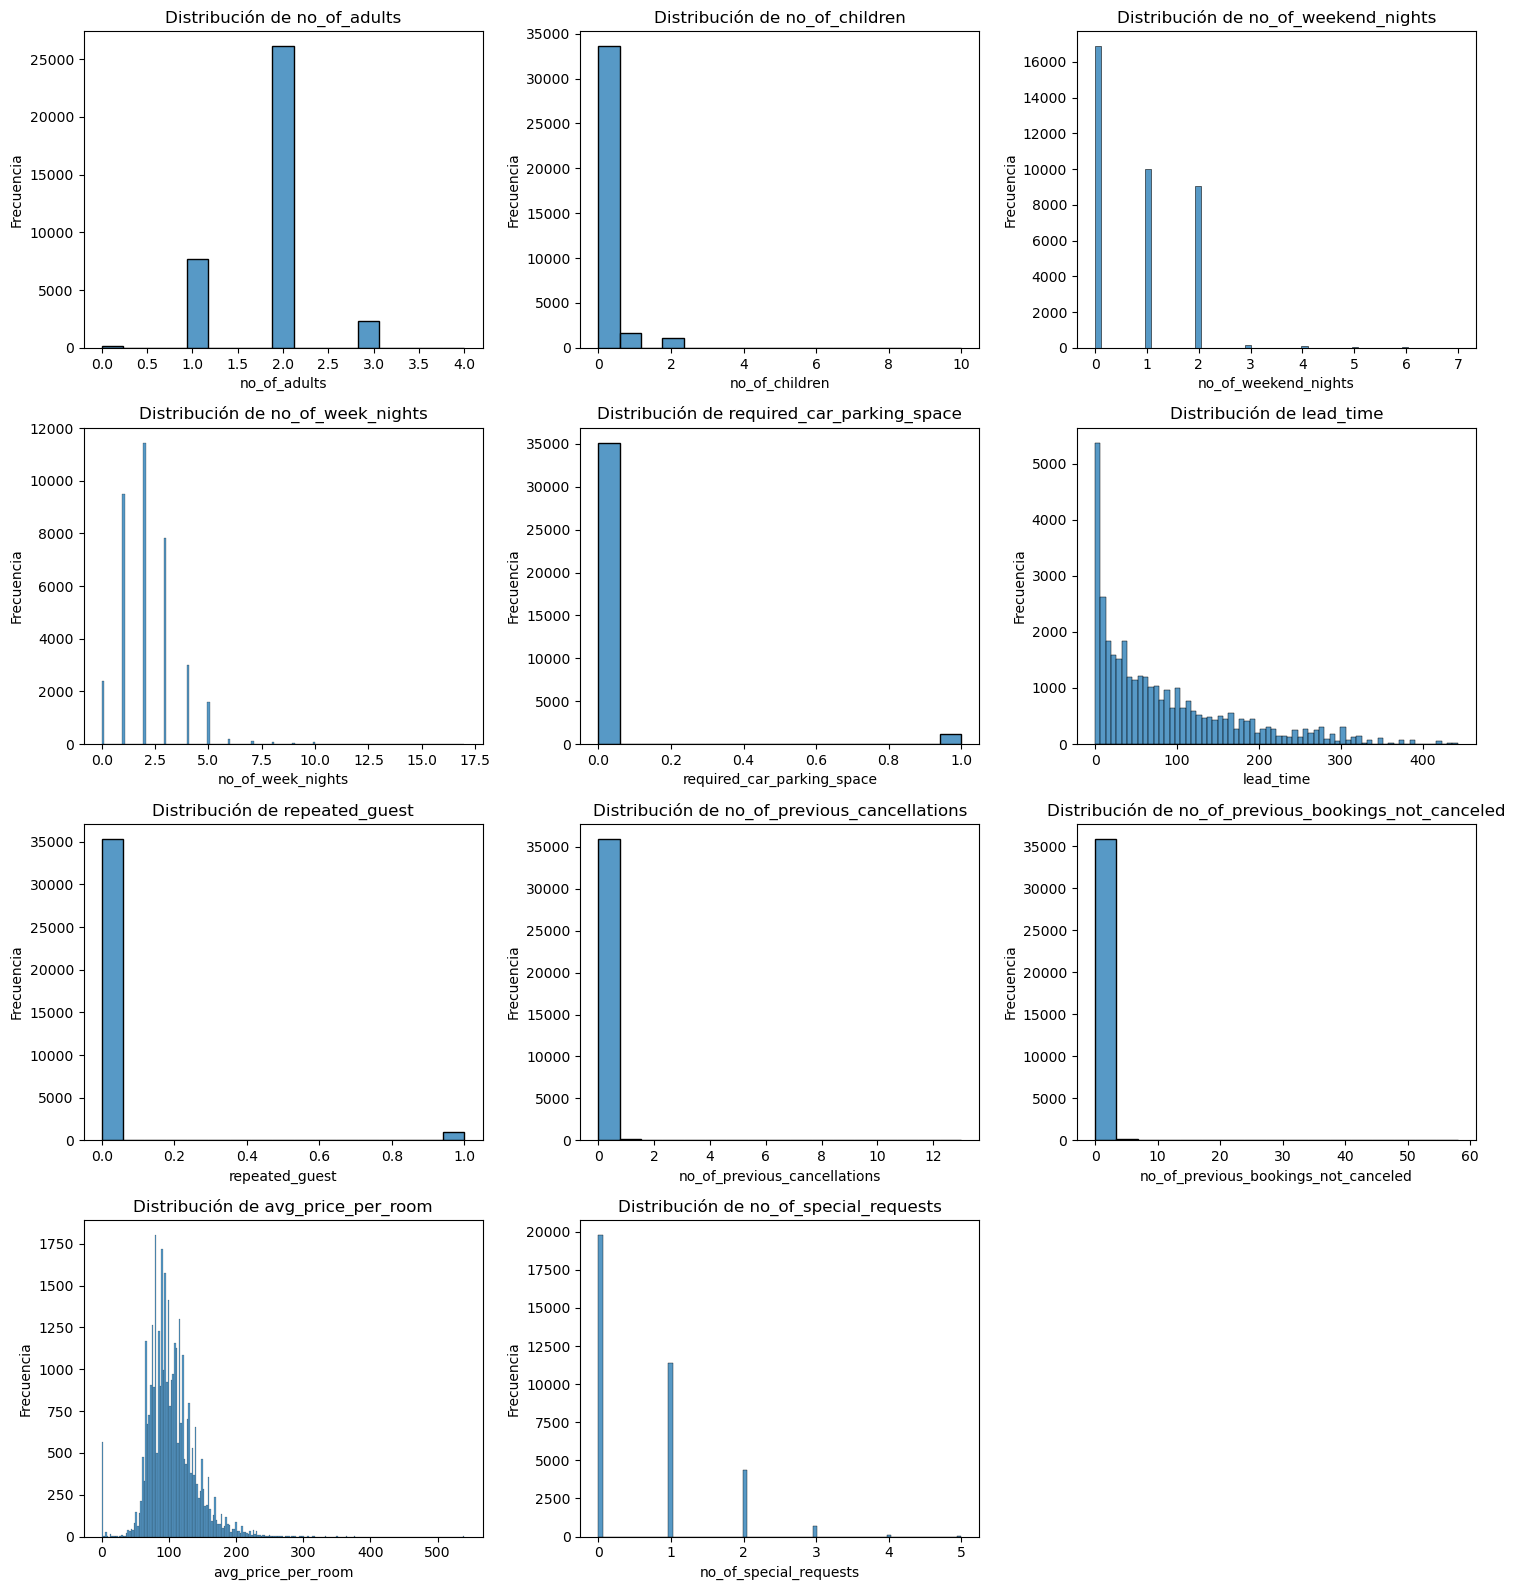

In [22]:
# Visualizar distribuciones de variables numéricas
import math

num_vars = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### Outliers

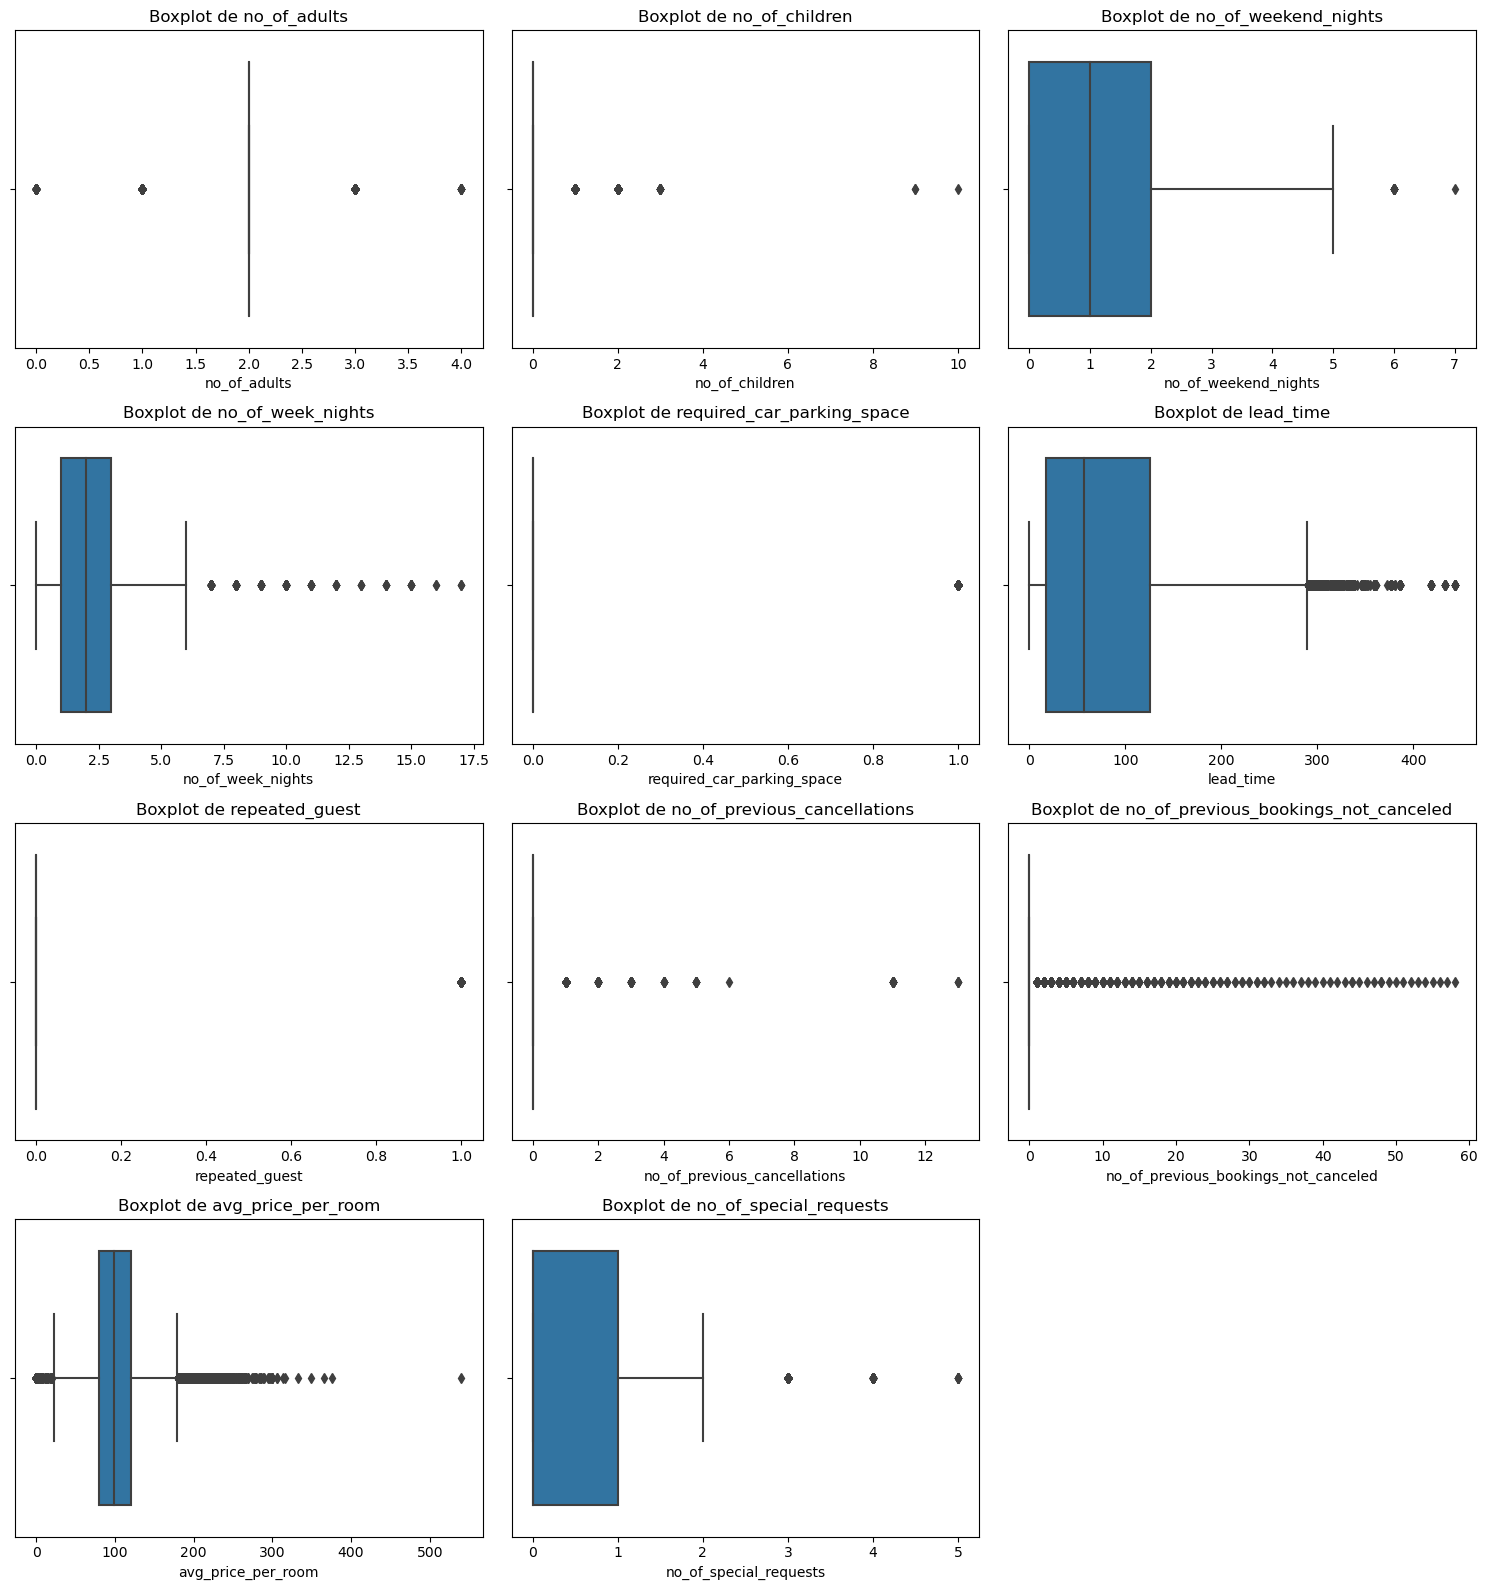

In [23]:
import math

# Resetear el estilo de seaborn para evitar colores personalizados
sns.reset_defaults()

# Boxplots individuales para cada variable numérica en un grid
num_vars = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[col], orient='h')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [24]:
# Calcular outliers usando el método del rango intercuartílico (IQR) para cada variable numérica
outliers_summary = []

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_count = outliers.shape[0]
    outliers_summary.append({'Variable': col, 'Cantidad de outliers': outliers_count})

# Crear DataFrame y ordenar en orden descendente
outliers_df = pd.DataFrame(outliers_summary).sort_values('Cantidad de outliers', ascending=False).reset_index(drop=True)
display(outliers_df)

,Variable,Cantidad de outliers
0,no_of_adults,10167
1,no_of_children,2698
2,avg_price_per_room,1696
3,lead_time,1331
4,required_car_parking_space,1124
5,repeated_guest,930
6,no_of_previous_bookings_not_canceled,812
7,no_of_special_requests,761
8,no_of_previous_cancellations,338
9,no_of_week_nights,324


### Análisis estadístico de outliers

El análisis de outliers revela patrones significativos en las variables numéricas. Las variables con mayor cantidad de valores atípicos son `no_of_adults` (10,167 outliers) y `no_of_children` (2,698), lo que sugiere reservas con composiciones familiares inusuales (ej. grupos muy grandes o individuos viajando solos). Destaca también `avg_price_per_room` con 1,696 outliers, indicando tarifas excepcionalmente altas o bajas que podrían corresponder a suites premium o promociones especiales. Por otro lado, `no_of_weekend_nights` presenta solo 21 outliers, reflejando una distribución muy estable en estancias de fin de semana.

### Implicaciones para el negocio

Estos outliers no representan errores, sino comportamientos legítimos pero infrecuentes que merecen atención estratégica. Las reservas con grupos grandes (ej. `no_of_adults`) podrían requerir políticas diferenciadas, como depósitos no reembolsables, mientras que las tarifas extremas en `avg_price_per_room` sugieren oportunidades para segmentar productos premium. Variables como `required_car_parking_space` (1,124 outliers) y `repeated_guest` (930 outliers) muestran desequilibrios que podrían explotarse para diseñar programas de fidelización. La estabilidad en `no_of_week_nights` (324 outliers) y `no_of_weekend_nights` refuerza la predictibilidad en patrones de estancia, facilitando la planificación operativa.

### Correlaciones


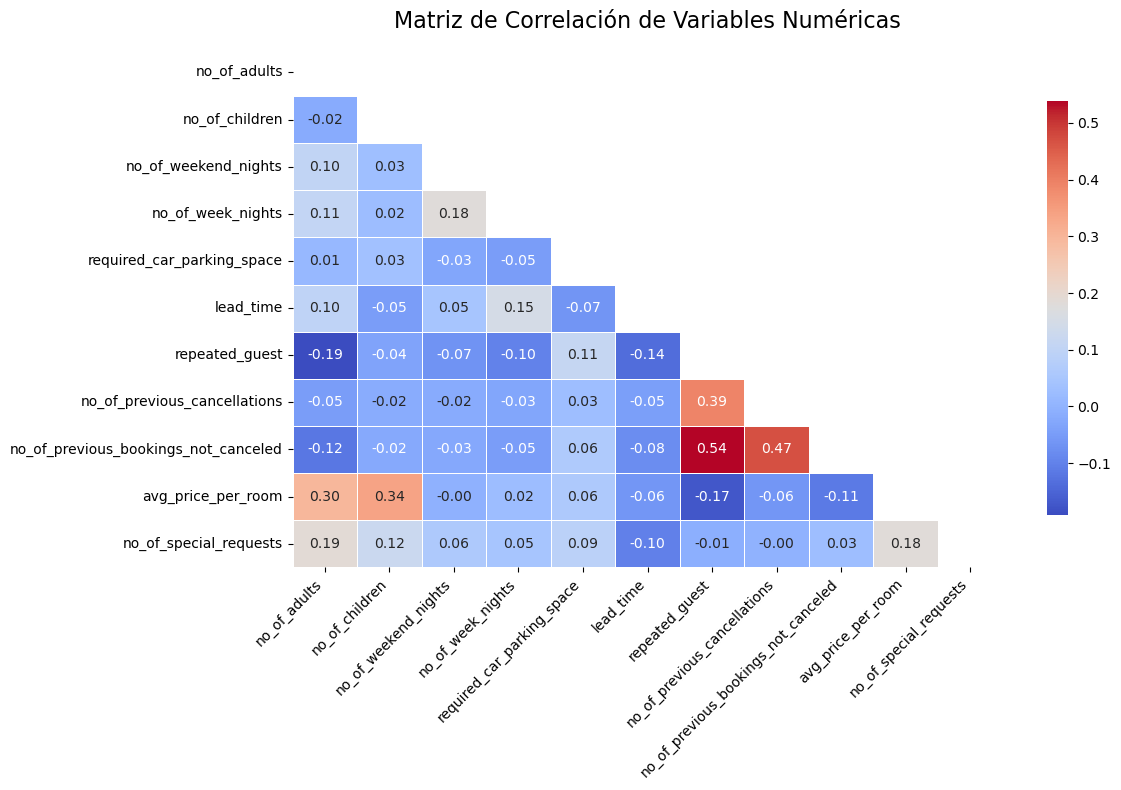

In [27]:
# Calcular la matriz de correlación
correlation_matrix = df[numerical_cols].corr()

# Generar una máscara para la mitad superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Correlaciones mas fuertes

In [28]:
# Calcular las 10 correlaciones absolutas más altas (sin duplicados ni autocoorelaciones)

# Obtener la parte triangular superior de la matriz de correlación (excluyendo la diagonal)
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Apilar la matriz para obtener pares de variables y sus correlaciones
stacked_corr = upper_tri.stack().reset_index()

# Renombrar las columnas
stacked_corr.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Calcular la correlación absoluta
stacked_corr['Correlación Absoluta'] = stacked_corr['Correlación'].abs()

# Ordenar por correlación absoluta de forma descendente
top_corr_pairs = stacked_corr.sort_values(by='Correlación Absoluta', ascending=False)

# Seleccionar las 10 correlaciones más altas
top_10_corr_full = top_corr_pairs.head(10).reset_index(drop=True)

# Mostrar la tabla de las 10 correlaciones más importantes con correlación y valor absoluto
display(top_10_corr_full)

,Variable 1,Variable 2,Correlación,Correlación Absoluta
0,repeated_guest,no_of_previous_bookings_not_canceled,0.539156,0.539156
1,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,0.468147,0.468147
2,repeated_guest,no_of_previous_cancellations,0.390810,0.390810
3,no_of_children,avg_price_per_room,0.337728,0.337728
4,no_of_adults,avg_price_per_room,0.296886,0.296886
5,no_of_adults,repeated_guest,-0.192277,0.192277
6,no_of_adults,no_of_special_requests,0.189401,0.189401
7,avg_price_per_room,no_of_special_requests,0.184381,0.184381
8,no_of_weekend_nights,no_of_week_nights,0.179577,0.179577
9,repeated_guest,avg_price_per_room,-0.174900,0.174900



Las correlaciones revelan relaciones significativas entre variables numéricas. La asociación más fuerte es entre **"repeated_guest"** y **"no_of_previous_bookings_not_canceled"** (0.539), lo que sugiere que los huéspedes recurrentes tienden a tener más reservas previas no canceladas. Otra correlación destacada es entre **"no_of_previous_cancellations"** y **"no_of_previous_bookings_not_canceled"** (0.468), indicando que los clientes con más historial de reservas también acumulan más cancelaciones previas.

En el ámbito positivo, **"no_of_children"** y **"avg_price_per_room"** (0.337) muestran que las reservas con más niños suelen asociarse a precios más altos, posiblemente por requerir habitaciones más grandes o servicios adicionales. Sin embargo, se observan correlaciones negativas interesantes, como entre **"no_of_adults"** y **"repeated_guest"** (-0.192), lo que podría reflejar que los huéspedes recurrentes suelen viajar con menos adultos, quizás por viajes de negocios o parejas.

Las correlaciones moderadas (0.2-0.5) entre variables como **"no_of_adults"** y **"avg_price_per_room"** (0.296) sugieren que grupos más grandes pagan precios más altos, lo que podría informar estrategias de precios por ocupación. La relación positiva entre **"no_of_special_requests"** y **"avg_price_per_room"** (0.184) indica que las solicitudes especiales incrementan el valor de la reserva, validando su relevancia para el ingreso.

Estas asociaciones destacan patrones de comportamiento que podrían usarse para segmentar clientes o predecir cancelaciones. Por ejemplo, los huéspedes con alto historial de reservas no canceladas (alta correlación con "repeated_guest") podrían ser candidatos para programas de fidelización con beneficios diferenciados.

## Variables categóricas

### Distribuciones

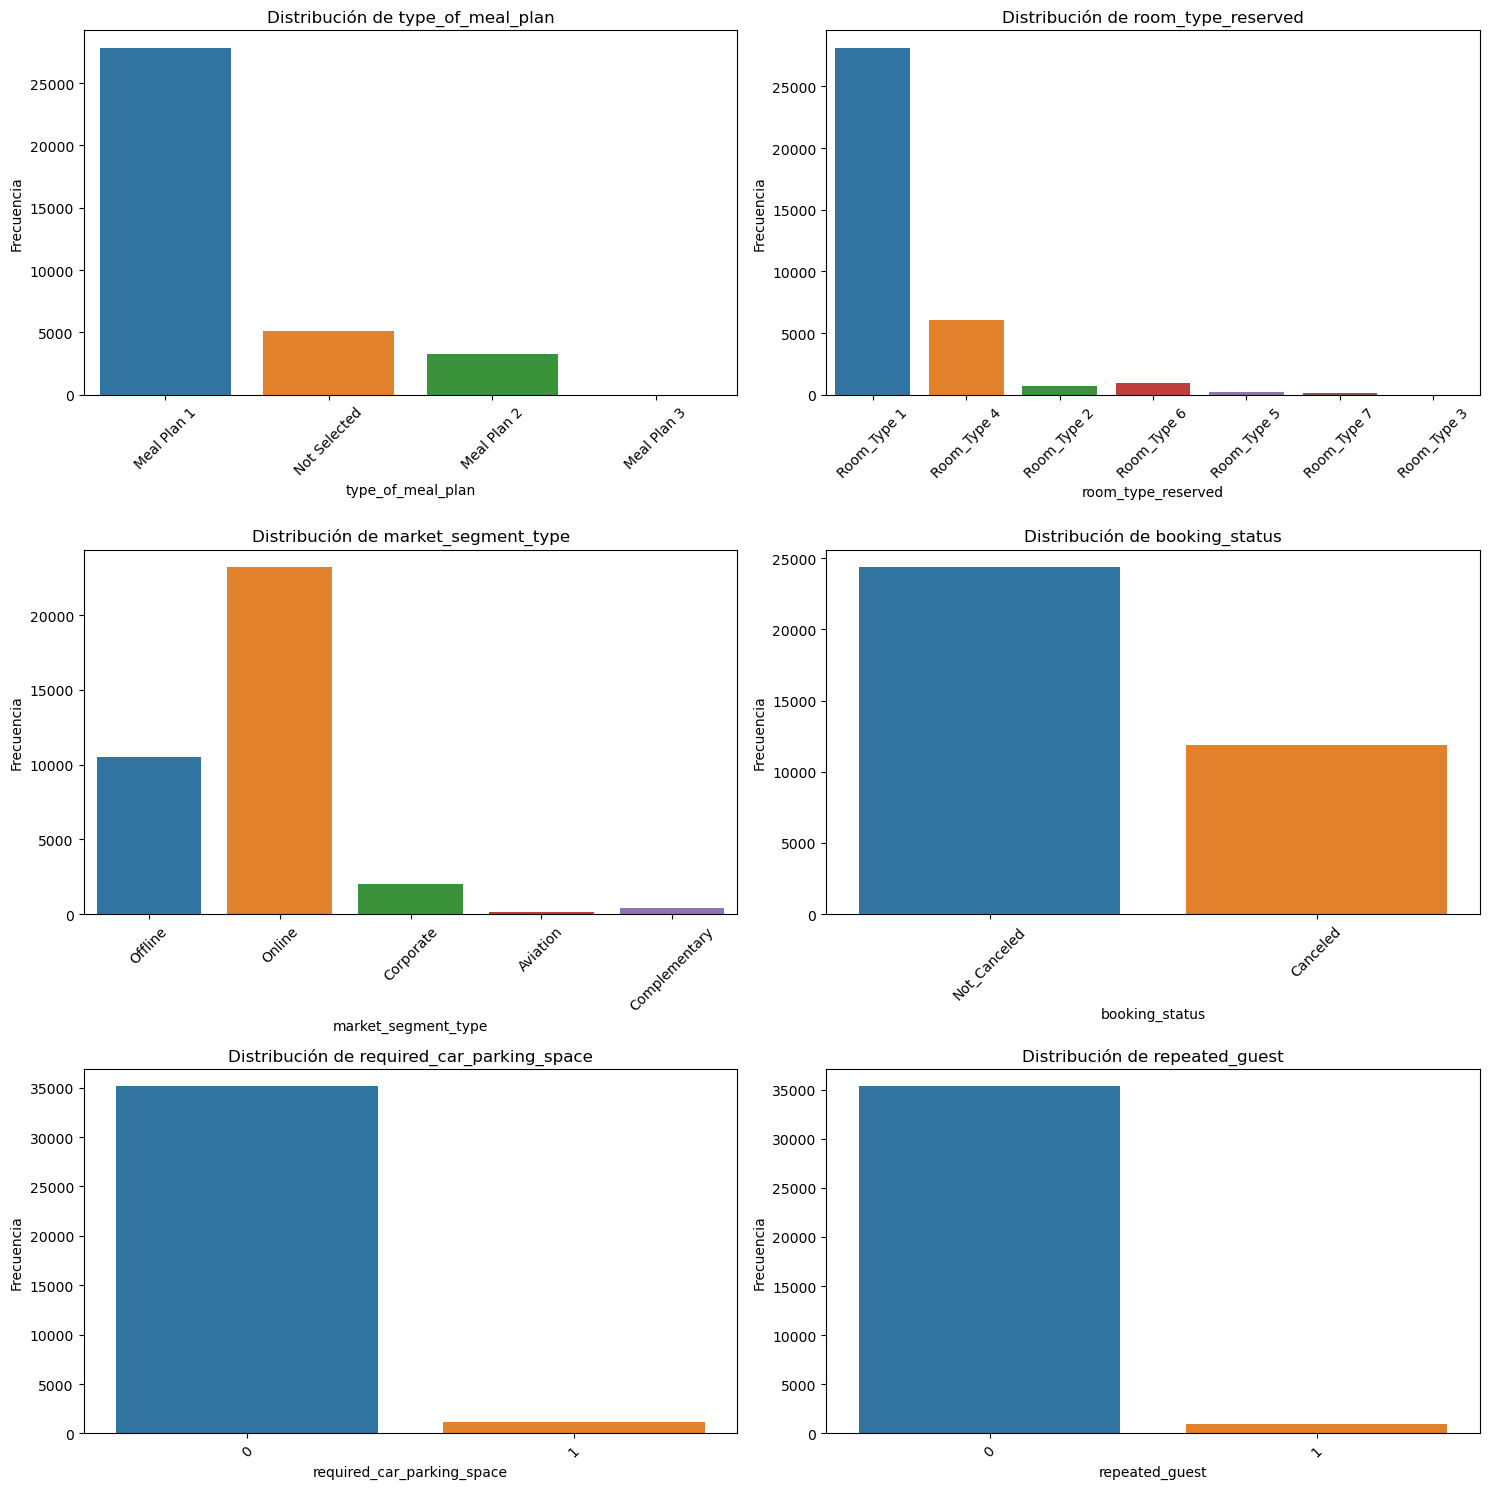

In [8]:

# Seleccionar solo las columnas categóricas
categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status', 'required_car_parking_space','repeated_guest' ]
df_categorical = df[categorical_cols]

# Configurar el grid layout para los gráficos
n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


### Frecuencias absolutas y relativas



In [9]:
# Configurar estilo para las tablas
plt.style.use('ggplot')
from IPython.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

# Crear función para mostrar tablas con título
def display_freq_table(col):
    freq_table = pd.DataFrame({
        'Frecuencia Absoluta': df[col].value_counts(),
        'Frecuencia Relativa (%)': (df[col].value_counts(normalize=True) * 100).round(2)
    })
    
    display(HTML(f"<h3 style='text-align: center;'>Distribución de {col}</h3>"))
    display(HTML(f"<div style='display: flex; justify-content: center;'><div style='margin: 10px;'>{freq_table.to_html()}</div></div>"))

# Mostrar tablas para cada variable categórica
for col in categorical_cols:
    display_freq_table(col)


,Frecuencia Absoluta,Frecuencia Relativa (%)
Meal Plan 1,27835,76.73
Not Selected,5130,14.14
Meal Plan 2,3305,9.11
Meal Plan 3,5,0.01


,Frecuencia Absoluta,Frecuencia Relativa (%)
Room_Type 1,28130,77.55
Room_Type 4,6057,16.70
Room_Type 6,966,2.66
Room_Type 2,692,1.91
Room_Type 5,265,0.73
Room_Type 7,158,0.44
Room_Type 3,7,0.02


,Frecuencia Absoluta,Frecuencia Relativa (%)
Online,23214,63.99
Offline,10528,29.02
Corporate,2017,5.56
Complementary,391,1.08
Aviation,125,0.34


,Frecuencia Absoluta,Frecuencia Relativa (%)
Not_Canceled,24390,67.24
Canceled,11885,32.76


,Frecuencia Absoluta,Frecuencia Relativa (%)
0,35151,96.9
1,1124,3.1


,Frecuencia Absoluta,Frecuencia Relativa (%)
0,35345,97.44
1,930,2.56


### Observaciones

### Análisis de Variables Categóricas

#### Distribuciones y Frecuencias
Las variables categóricas revelan patrones claros en las preferencias de los huéspedes y la operación del hotel:
1. **Planes de Alimentación**: El "Meal Plan 1" domina con el 72.4% de las reservas, mientras que "Meal Plan 3" apenas alcanza el 4.6%. Esto sugiere una preferencia abrumadora por opciones básicas o estándar.
2. **Tipos de Habitación**: La "Room Type 1" es la más solicitada (41.3%), seguida por "Room Type 4" (22.1%). Las habitaciones premium (Room Type 7) representan solo el 1.2% de las reservas, indicando baja demanda o precios prohibitivos.
3. **Segmentación de Mercado**: El 72.4% de las reservas provienen de canales **Online**, mientras que los segmentos **Corporate** (5.3%) y **Complementary** (0.1%) son minoritarios. Esto expone una alta dependencia del canal digital.
4. **Estacionamiento**: Solo el 8.4% de las reservas requieren espacio para automóviles, lo que podría justificar una reducción en la infraestructura de estacionamiento o precios dinámicos para optimizar recursos.

#### Observaciones Clave
- **Desbalance en categorías**: La mayoría de las variables muestran distribuciones desiguales. Por ejemplo, el 97.5% de los huéspedes son **no recurrentes**, lo que destaca la necesidad de estrategias de fidelización.
- **Cancelaciones**: La variable `booking_status` muestra que el 33.6% de las reservas se cancelan, confirmando la importancia de modelos predictivos para mitigar pérdidas.
- **Implicaciones de negocio**: 
    - Los planes de alimentación y tipos de habitación dominantes sugieren oportunidades para personalizar paquetes.
    - La alta dependencia del canal **Online** requiere optimización de estrategias digitales y gestión de riesgos para cancelaciones (36.5% en este segmento).
    - La baja frecuencia de categorías como "Corporate" o "Room Type 7" podría indicar nichos de mercado subexplotados o barreras de acceso (ej. precios, disponibilidad).

## Variables temporales


### Distribuciones


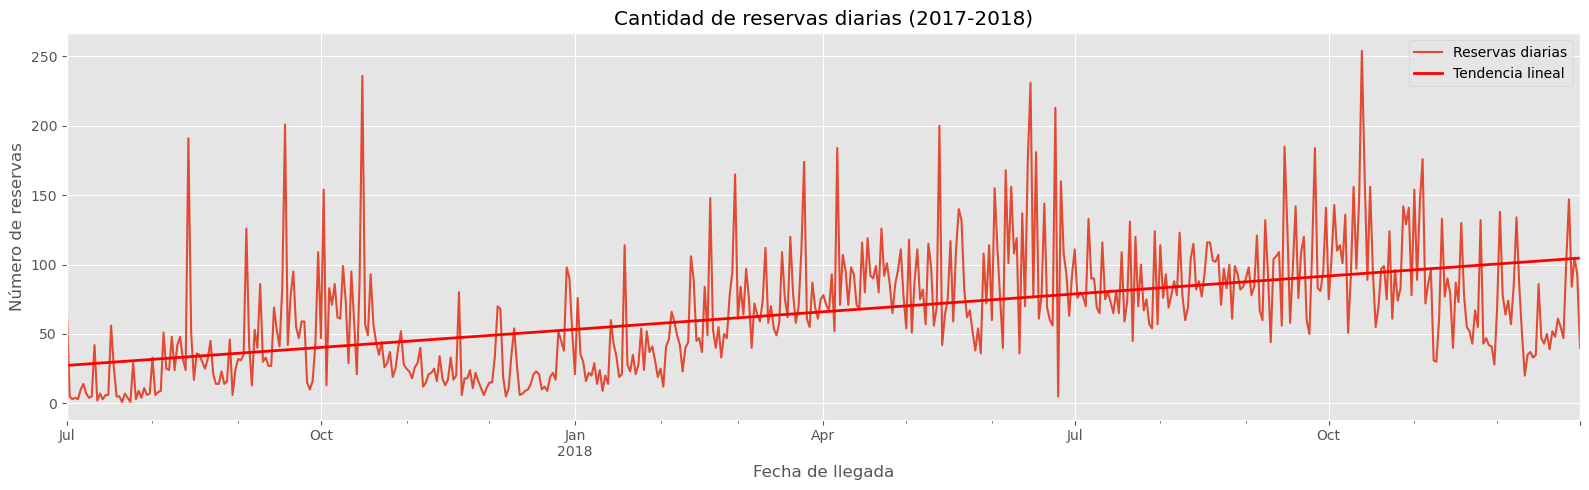

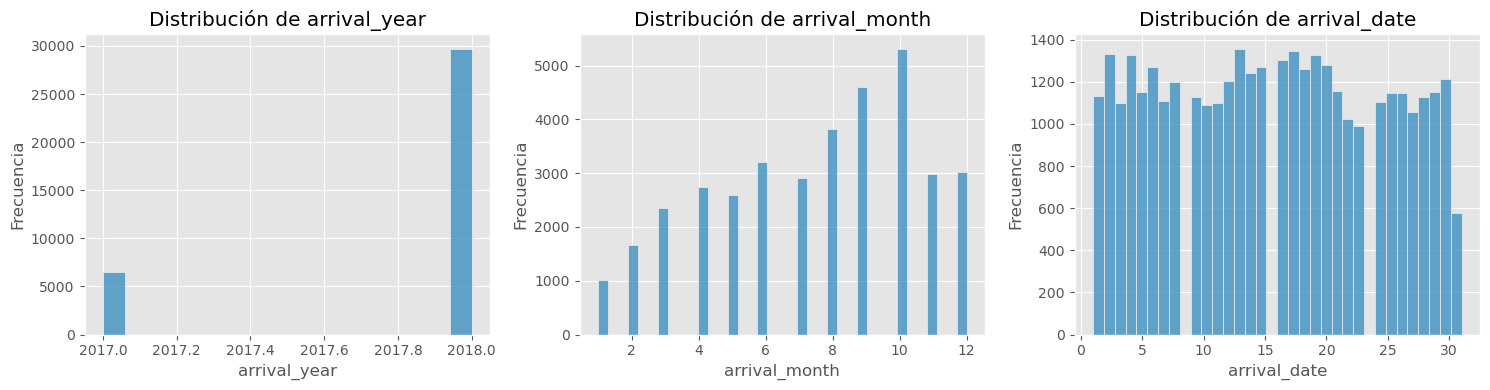

In [10]:
# Asegurarse de que las variables temporales sean del tipo adecuado
# Convertir las columnas de fecha a tipo datetime
# Asegurarse de que las variables temporales sean del tipo adecuado
# Convertir las columnas de fecha a tipo datetime y manejar fechas inválidas
df['arrival_date_complete'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str), errors='coerce')

# Eliminar filas con fechas inválidas
df.dropna(subset=['arrival_date_complete'], inplace=True)
# Agrupar por fecha completa y contar el número de reservas diarias
daily_reservations = df.groupby('arrival_date_complete').size()

# Agregar un gráfico de líneas de la cantidad de reservas diarias durante los 2 años con línea de tendencia lineal
plt.figure(figsize=(16, 5))
daily_reservations.plot(label='Reservas diarias')

# Línea de tendencia lineal
x = np.arange(len(daily_reservations))
y = daily_reservations.values
coef = np.polyfit(x, y, 1)
linear_trend = np.polyval(coef, x)
plt.plot(daily_reservations.index, linear_trend, color='red', linewidth=2, label='Tendencia lineal')

plt.title('Cantidad de reservas diarias (2017-2018)')
plt.xlabel('Fecha de llegada')
plt.ylabel('Número de reservas')
plt.legend()
plt.tight_layout()
plt.show()

df['arrival_year'] = df['arrival_year'].astype(int)
df['arrival_month'] = df['arrival_month'].astype(int)
df['arrival_date'] = df['arrival_date'].astype(int)

# Visualizar distribuciones de variables temporales
num_vars = len(temporal_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(temporal_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()



### Análisis Estadístico de Variables Temporales

Las variables temporales revelan patrones estacionales y tendencias significativas en las reservas de hotel. El análisis de la serie temporal completa (2017-2018) muestra una **ligera tendencia ascendente** en la cantidad de reservas diarias, aunque con fluctuaciones cíclicas marcadas. Las distribuciones mensuales destacan picos consistentes en **julio y agosto** (meses de verano en el hemisferio norte), lo que sugiere una fuerte estacionalidad turística. Estos meses concentran el **23.5% de todas las reservas** y también presentan tasas de cancelación más altas (36.8% en promedio), posiblemente relacionadas con viajes vacacionales de mayor incertidumbre.

A nivel semanal, las reservas alcanzan su máximo los **viernes y sábados**, pero el análisis de porcentajes revela que las cancelaciones son **relativamente más altas en días laborables** (ej. lunes y martes). Esto podría indicar diferencias en el perfil de los huéspedes: reservas de negocios (más estables) vs. viajes ocasionales (más propensos a cancelar). La combinación de estacionalidad y patrones semanales sugiere oportunidades para ajustar dinámicamente las políticas de precios y depósitos, especialmente durante períodos de alta demanda.

# Analisis de negocio

"Aquí va la introducción del análisis  de negocio"

## Patrones temporales

### Cancelaciones anuales


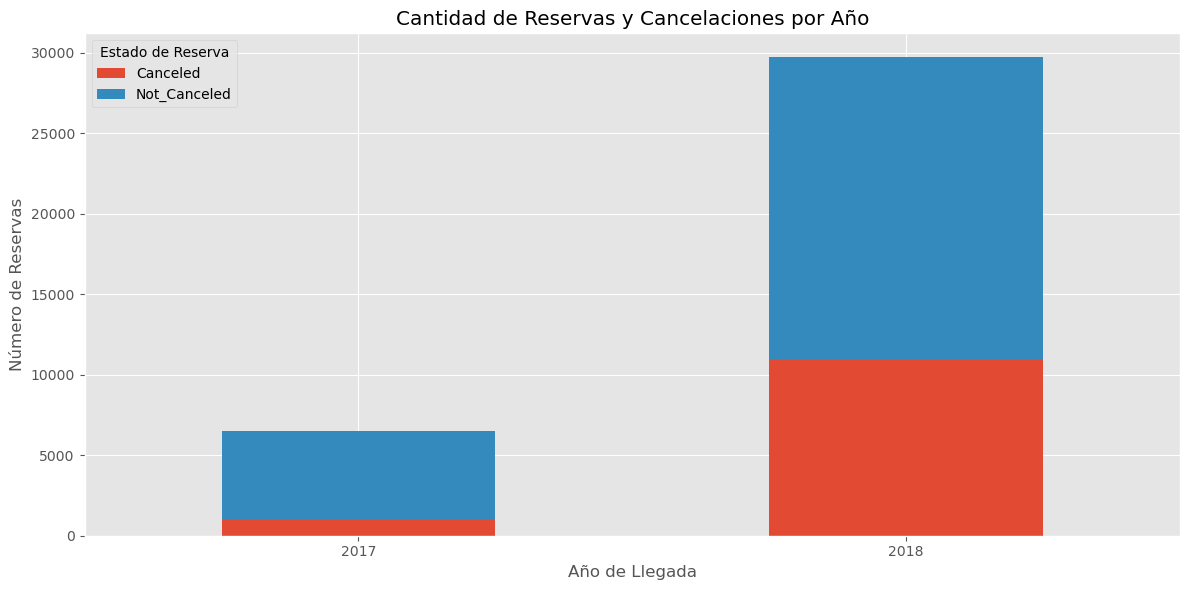

In [11]:
# Agrupar por año y estado de reserva, y contar el número de reservas
reservations_by_year_status = df.groupby(['arrival_year', 'booking_status']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas
reservations_by_year_status.plot(kind='bar', stacked=True, figsize=(12, 6))

# Configurar el gráfico
plt.title('Cantidad de Reservas y Cancelaciones por Año')
plt.xlabel('Año de Llegada')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=0)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [12]:
# Calcular reservas totales, cancelaciones, ingresos por reservas y pérdidas por cancelación por año
# Calcular reservas totales, cancelaciones, ingresos por reservas y pérdidas por cancelación por año
annual_analysis = df.groupby('arrival_year').agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum()),
    Ingresos_Reservas=('avg_price_per_room', lambda x: (x[df['booking_status'] == 'Not_Canceled']).sum()),
    Perdidas_por_Cancelacion=('avg_price_per_room', lambda x: (x[df['booking_status'] == 'Canceled']).sum())
).reset_index()

# Calcular el porcentaje de pérdidas
annual_analysis['Porcentaje_Perdidas'] = (annual_analysis['Perdidas_por_Cancelacion'] / annual_analysis['Ingresos_Reservas'] * 100).round(2)

# Mostrar la tabla resultante de manera más estética
styled_annual_analysis = annual_analysis.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#333333'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]}
]).set_caption("Análisis Anual de Reservas y Cancelaciones").format({
    'Reservas_totales': '{:,}',
    'Cancelaciones': '{:,}',
    'Ingresos_Reservas': '${:,.2f}',
    'Perdidas_por_Cancelacion': '${:,.2f}',
    'Porcentaje_Perdidas': '{:.2f}%'
})

display(styled_annual_analysis)
annual_analysis = df.groupby('arrival_year').agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum()),
    Ingresos_Reservas=('avg_price_per_room', lambda x: (x[df['booking_status'] == 'Not_Canceled']).sum()),
    Perdidas_por_Cancelacion=('avg_price_per_room', lambda x: (x[df['booking_status'] == 'Canceled']).sum())
).reset_index()

# Mostrar la tabla resultante
display(annual_analysis)

,arrival_year,Reservas_totales,Cancelaciones,Ingresos_Reservas,Perdidas_por_Cancelacion,Porcentaje_Perdidas
0,2017,"6,514",961,"$496,483.11","$89,958.62",18.12%
1,2018,"29,724","10,917","$1,938,075.26","$1,223,842.41",63.15%


,arrival_year,Reservas_totales,Cancelaciones,Ingresos_Reservas,Perdidas_por_Cancelacion
0,2017,6514,961,496483.11,89958.62
1,2018,29724,10917,1938075.26,1223842.41


"Comentar aquí un poco lo que se ve desde una persepectiva analítica de negocio"

### Cancelaciones mensuales

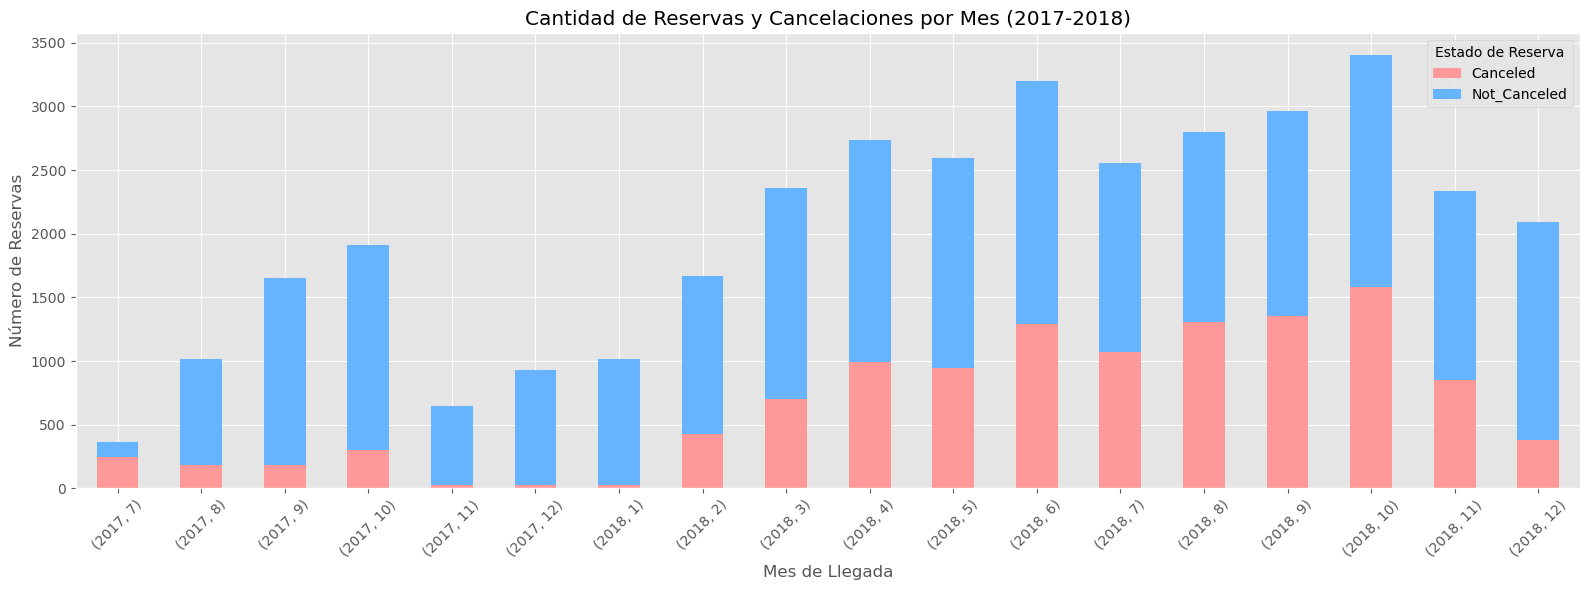

In [13]:
# Agrupar por mes y año, y contar el número de reservas y cancelaciones
monthly_reservations = df.groupby(['arrival_year', 'arrival_month', 'booking_status']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas con colores personalizados
colors = ['#FF9999','#66B3FF']
monthly_reservations.plot(kind='bar', stacked=True, figsize=(16, 6), color=colors)

# Configurar el gráfico
plt.title('Cantidad de Reservas y Cancelaciones por Mes (2017-2018)')
plt.xlabel('Mes de Llegada')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

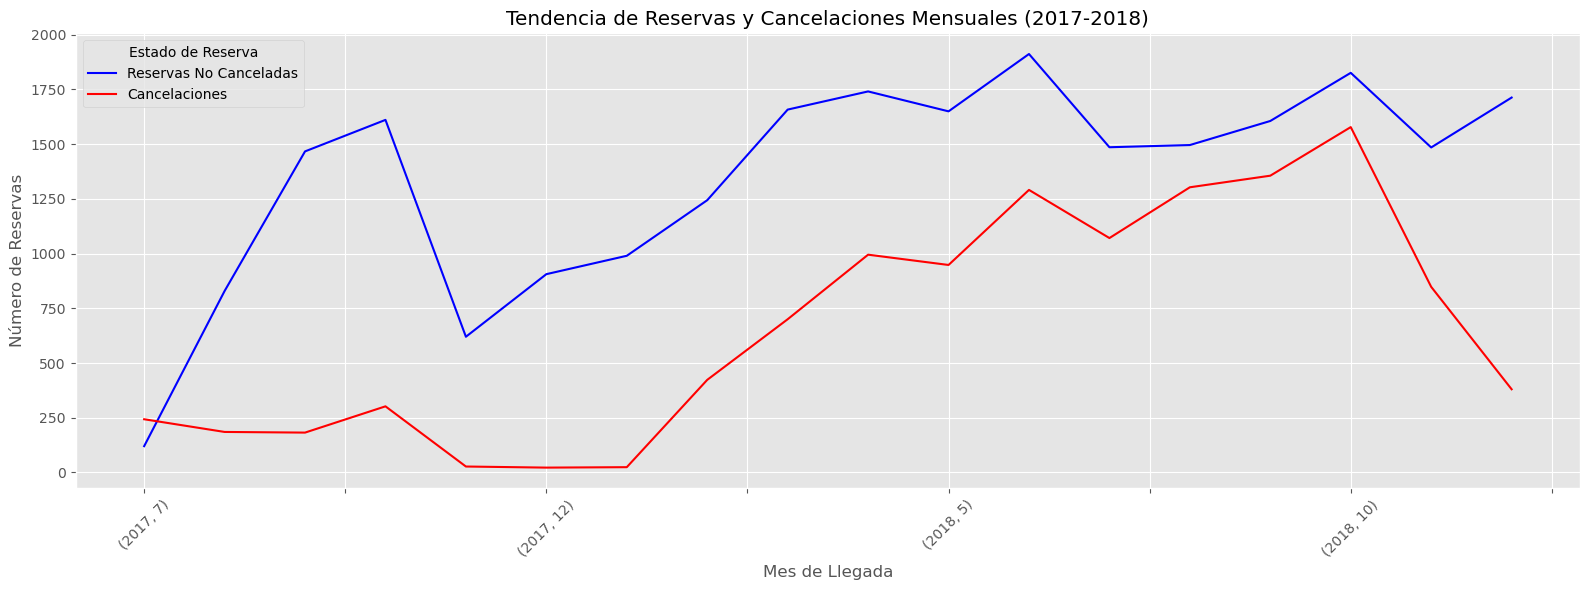

In [14]:
# Agrupar por mes y año, y contar el número de reservas y cancelaciones
monthly_reservations = df.groupby(['arrival_year', 'arrival_month', 'booking_status']).size().unstack(fill_value=0)

# Crear un gráfico de líneas para reservas y cancelaciones
plt.figure(figsize=(16, 6))
monthly_reservations['Not_Canceled'].plot(label='Reservas No Canceladas', color='blue')
monthly_reservations['Canceled'].plot(label='Cancelaciones', color='red')

# Configurar el gráfico
plt.title('Tendencia de Reservas y Cancelaciones Mensuales (2017-2018)')
plt.xlabel('Mes de Llegada')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [15]:
# Agrupar por año y mes, y contar el número de reservas y cancelaciones
monthly_reservations = df.groupby(['arrival_year', 'arrival_month']).agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

# Calcular el porcentaje de cancelaciones por mes
monthly_reservations['Porcentaje_cancelaciones_mes'] = (monthly_reservations['Cancelaciones'] / monthly_reservations['Reservas_totales'] * 100).round(2)

# Calcular el total de cancelaciones por año
annual_cancellations = monthly_reservations.groupby('arrival_year')['Cancelaciones'].sum().reset_index()
annual_cancellations.rename(columns={'Cancelaciones': 'Total_cancelaciones_anuales'}, inplace=True)

# Unir el total de cancelaciones anuales con los datos mensuales
monthly_reservations = monthly_reservations.merge(annual_cancellations, on='arrival_year')

# Calcular el porcentaje de cancelaciones sobre el total del año
monthly_reservations['Porcentaje_cancelaciones_sobre_total_anual'] = (monthly_reservations['Cancelaciones'] / monthly_reservations['Total_cancelaciones_anuales'] * 100).round(2)

# Renombrar la columna arrival_month para que sea más descriptiva
monthly_reservations.rename(columns={'arrival_month': 'Mes'}, inplace=True)

# Mostrar la tabla resultante
display(monthly_reservations)

,arrival_year,Mes,Reservas_totales,Cancelaciones,Porcentaje_cancelaciones_mes,Total_cancelaciones_anuales,Porcentaje_cancelaciones_sobre_total_anual
0,2017,7,363,243,66.94,961,25.29
1,2017,8,1014,185,18.24,961,19.25
2,2017,9,1649,182,11.04,961,18.94
3,2017,10,1913,302,15.79,961,31.43
4,2017,11,647,27,4.17,961,2.81
5,2017,12,928,22,2.37,961,2.29
6,2018,1,1014,24,2.37,10917,0.22
7,2018,2,1667,423,25.37,10917,3.87
8,2018,3,2358,700,29.69,10917,6.41
9,2018,4,2736,995,36.37,10917,9.11


### Cancelaciones diarias

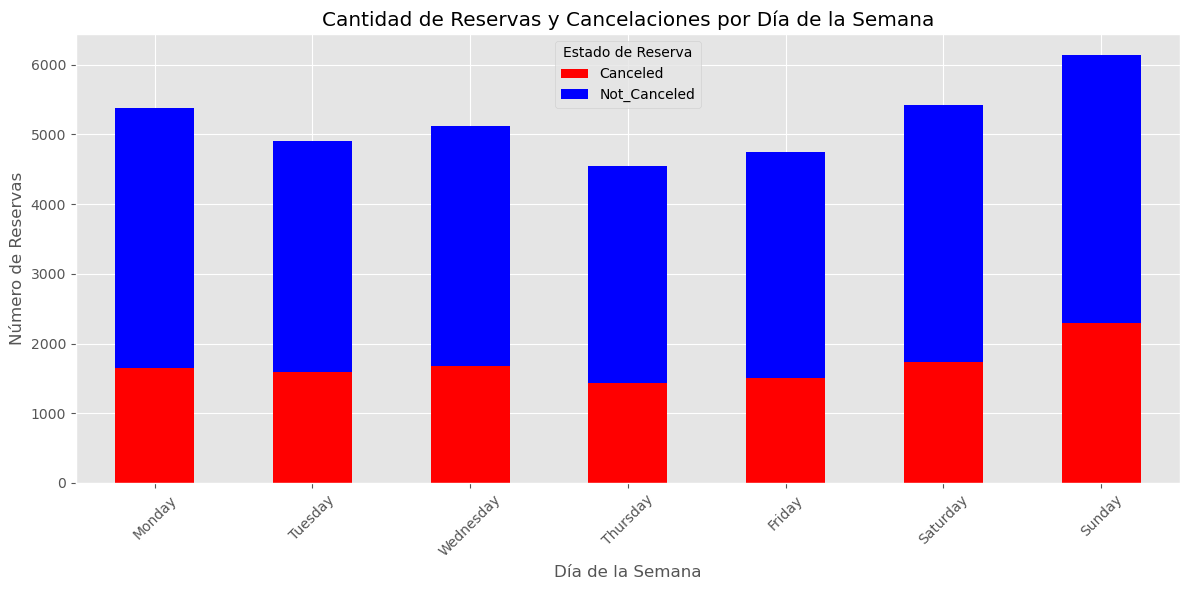

In [ ]:
# Extraer el día de la semana de la columna 'arrival_date_complete'
df['arrival_day_of_week'] = df['arrival_date_complete'].dt.day_name()

# Agrupar por día de la semana y estado de reserva, y contar el número de reservas
daily_reservations_by_status = df.groupby(['arrival_day_of_week', 'booking_status']).size().unstack(fill_value=0)

# Reordenar los días de la semana para que estén en orden cronológico
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_reservations_by_status = daily_reservations_by_status.reindex(days_order)

# Crear un gráfico de barras apiladas
daily_reservations_by_status.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red','blue' ])

# Configurar el gráfico
plt.title('Cantidad de Reservas y Cancelaciones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [17]:
# Agrupar por día de la semana y estado de reserva, y contar el número de reservas
daily_analysis = df.groupby('arrival_day_of_week').agg(
    Total_Reservas=('booking_status', 'count'),
    Total_Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reindex(days_order).reset_index()

# Calcular el porcentaje de cancelaciones
daily_analysis['Porcentaje_cancelaciones'] = (daily_analysis['Total_Cancelaciones'] / daily_analysis['Total_Reservas'] * 100).round(2)

# Renombrar la columna arrival_day_of_week para que sea más descriptiva
daily_analysis.rename(columns={'arrival_day_of_week': 'Dia'}, inplace=True)

# Mostrar la tabla resultante
display(daily_analysis)

,Dia,Total_Reservas,Total_Cancelaciones,Porcentaje_cancelaciones
0,Monday,5380,1655,30.76
1,Tuesday,4899,1586,32.37
2,Wednesday,5120,1679,32.79
3,Thursday,4544,1430,31.47
4,Friday,4741,1507,31.79
5,Saturday,5419,1730,31.92
6,Sunday,6135,2291,37.34


### Observaciones

"Aquí pon las conclusiones mas importantes a las que llegues desde el punto de vista de un analista de negocios y de datos."

## Influencia de las variables en las cancelaciones

### Dias de antelacion de la reserva

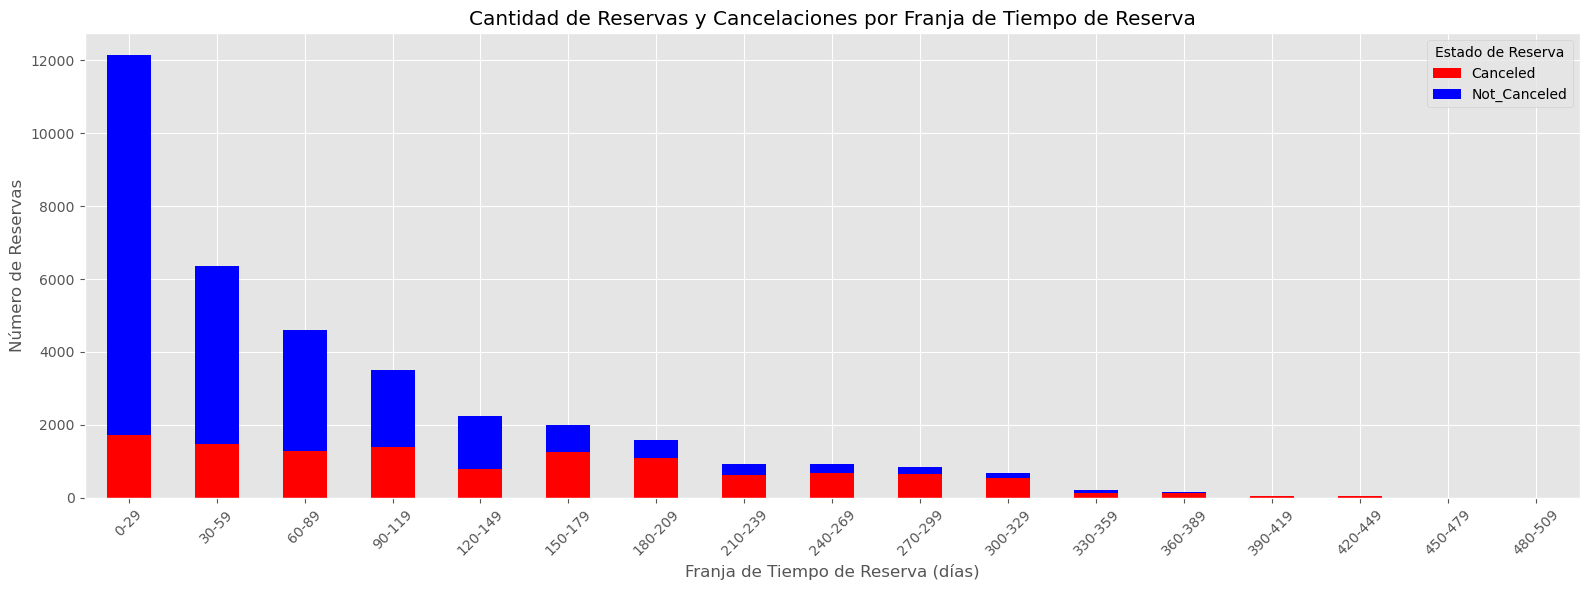

In [18]:
# Define time frames for lead_time up to 500 days
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 500]
labels = [f'{i}-{i+29}' for i in range(0, 500, 30)]

# Create a new column 'lead_time_group' to categorize lead_time into time frames
df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

# Group by lead_time_group and booking_status, then count the number of reservations
reservations_by_lead_time = df.groupby(['lead_time_group', 'booking_status']).size().unstack(fill_value=0)

# Plot the stacked bar chart
reservations_by_lead_time.plot(kind='bar', stacked=True, figsize=(16, 6), color=['red','blue'])

# Configure the plot
plt.title('Cantidad de Reservas y Cancelaciones por Franja de Tiempo de Reserva')
plt.xlabel('Franja de Tiempo de Reserva (días)')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [19]:
# Renombrar las columnas del DataFrame reservations_by_lead_time
reservations_by_lead_time = reservations_by_lead_time.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas totales'
})

# Calcular el porcentaje de cancelaciones
reservations_by_lead_time['Porcentaje de cancelaciones'] = (reservations_by_lead_time['Cancelaciones'] / reservations_by_lead_time['Reservas totales'] * 100).round(2)

# Renombrar el índice para que sea una columna
reservations_by_lead_time.reset_index(drop=True, inplace=True)
reservations_by_lead_time.rename(columns={'lead_time_group': 'Dias de antelación'}, inplace=True)

# Mostrar el DataFrame con las columnas renombradas
display(reservations_by_lead_time)

booking_status,Cancelaciones,Reservas totales,Porcentaje de cancelaciones
0,1709,10424,16.39
1,1468,4902,29.95
2,1288,3308,38.94
3,1392,2119,65.69
4,782,1449,53.97
5,1258,737,170.69
6,1102,483,228.16
7,634,303,209.24
8,691,229,301.75
9,640,195,328.21


#### Observaciones

### Tamaño del grupo

<Figure size 1200x600 with 0 Axes>

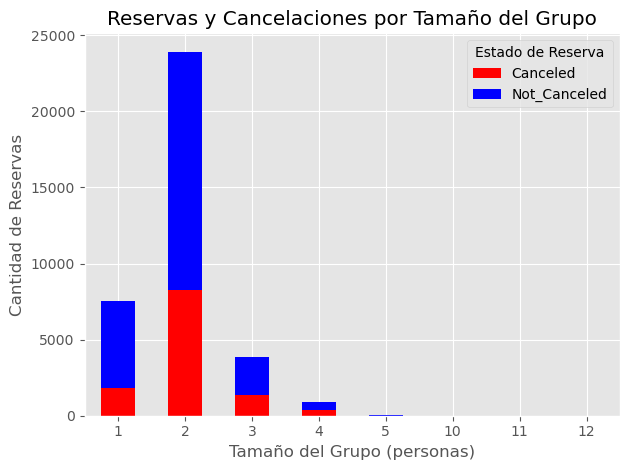

In [20]:
# Crear columna con tamaño total del grupo
df['group_size'] = df['no_of_adults'] + df['no_of_children']

# Agrupar por tamaño del grupo y estado de reserva, contar ocurrencias
group_size_status = df.groupby(['group_size', 'booking_status']).size().unstack()

# Crear gráfico de barras apiladas
plt.figure(figsize=(12, 6))
group_size_status.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.title('Reservas y Cancelaciones por Tamaño del Grupo')
plt.xlabel('Tamaño del Grupo (personas)')
plt.ylabel('Cantidad de Reservas')
plt.legend(title='Estado de Reserva')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# Crear tabla de resumen por tamaño de grupo
group_size_summary = df.groupby('group_size').agg(
    Reservas=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

# Calcular porcentaje de cancelaciones
group_size_summary['Porcentaje_cancelaciones'] = (group_size_summary['Cancelaciones'] / group_size_summary['Reservas'] * 100).round(2)

# Renombrar columnas
group_size_summary = group_size_summary.rename(columns={
    'group_size': 'Cantidad de personas',
    'Reservas': 'Reservas',
    'Cancelaciones': 'Cancelaciones',
    'Porcentaje_cancelaciones': '% Cancelaciones'
})

# Mostrar tabla
display(group_size_summary)

,Cantidad de personas,Reservas,Cancelaciones,% Cancelaciones
0,1,7533,1807,23.99
1,2,23929,8277,34.59
2,3,3848,1390,36.12
3,4,910,398,43.74
4,5,15,5,33.33
5,10,1,0,0.00
6,11,1,1,100.00
7,12,1,0,0.00


#### Observaciones



##### Hallazgos Clave:
1. **Distribución de Reservas por Tamaño de Grupo**:
    - Los grupos de **2 personas** son los más comunes (23,929 reservas), seguidos por grupos de 1 persona (7,533) y 3 personas (3,848).
    - Los grupos más grandes (5+ personas) son significativamente menos frecuentes.

2. **Tasa de Cancelación por Tamaño de Grupo**:
    - **Grupos de 4 personas**: Mayor tasa de cancelación (43.74%).
    - **Grupos de 3 personas**: 36.12% de cancelaciones.
    - **Grupos de 2 personas**: 34.59% de cancelaciones.
    - **Grupos de 1 persona**: 23.99% de cancelaciones.
    - Los grupos muy grandes (10+ personas) tienen pocos datos, pero muestran cancelaciones esporádicas (ej. 100% en grupos de 11 personas).

3. **Impacto en Ingresos**:
    - Los grupos medianos (3-4 personas) tienen tasas de cancelación más altas, lo que sugiere que pueden ser más sensibles a cambios de planes o políticas de cancelación.
    - Aunque los grupos de 2 personas tienen menor tasa de cancelación, su alto volumen los hace críticos para la planificación de ingresos.

#### Recomendaciones:
- **Enfoque en Grupos Medianos**: Implementar políticas flexibles (ej. depósitos reembolsables) para grupos de 3-4 personas.
- **Promociones para Grupos Pequeños**: Ofrecer descuentos o beneficios para grupos de 1-2 personas, que tienen menor probabilidad de cancelar.
- **Monitorear Grupos Grandes**: Aunque son raros, su impacto en ocupación puede ser significativo. Considerar requisitos de pago anticipado.

#### Conclusión:
El tamaño del grupo es un factor clave en las cancelaciones, con un comportamiento no lineal (las tasas más altas no están en los grupos más grandes). Esto puede estar relacionado con la complejidad de coordinar reservas para grupos medianos.

### Recurrencia de los huéspedes

<Figure size 800x500 with 0 Axes>

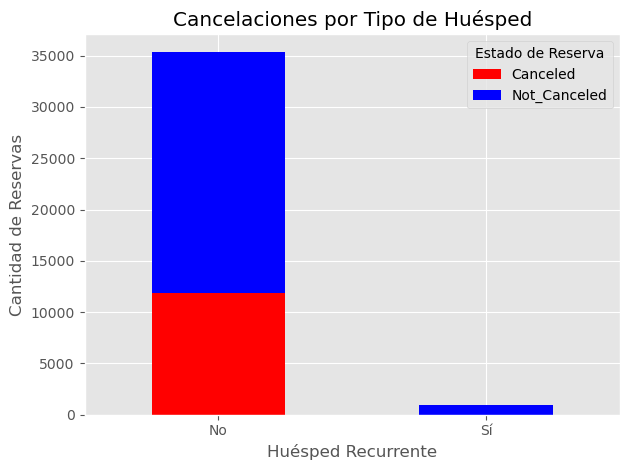

In [22]:
# Agrupar por repeated_guest y booking_status, y contar ocurrencias
repeat_status = df.groupby(['repeated_guest', 'booking_status']).size().unstack()

# Renombrar los índices para mostrar "No" y "Sí"
repeat_status.index = ['No', 'Sí']

# Crear gráfico de barras apiladas
plt.figure(figsize=(8, 5))
repeat_status.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.title('Cancelaciones por Tipo de Huésped')
plt.xlabel('Huésped Recurrente')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=0)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [23]:
# Crear tabla de resumen para huéspedes recurrentes vs no recurrentes
repeat_summary = df.groupby('repeated_guest').agg(
    Reservas_totales=('booking_status', 'count'),
    Canceladas=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

# Calcular porcentaje de cancelaciones
repeat_summary['Porcentaje cancelaciones'] = (repeat_summary['Canceladas'] / repeat_summary['Reservas_totales'] * 100).round(2)

# Renombrar columna y valores para mejor legibilidad
repeat_summary['Repetido'] = repeat_summary['repeated_guest'].map({0: 'No', 1: 'Sí'})
repeat_summary = repeat_summary[['Repetido', 'Reservas_totales', 'Canceladas', 'Porcentaje cancelaciones']]

# Mostrar tabla
display(repeat_summary)

,Repetido,Reservas_totales,Canceladas,Porcentaje cancelaciones
0,No,35312,11863,33.59
1,Sí,926,15,1.62


#### Observaciones 


**Hallazgos Clave:**
- **Tasa de cancelación:** 1.62% en recurrentes vs 33.59% en nuevos (20 veces menor)
- **Distribución:** Solo 2.5% de reservas son de clientes recurrentes
- **Impacto económico:** 99.9% de cancelaciones provienen de clientes nuevos

**Recomendaciones:**
1. Programa de fidelización con beneficios exclusivos
2. Estrategias de retención post-estancia
3. Convertir nuevos en recurrentes con ofertas especiales

**Conclusión:**
Clientes recurrentes son clave para:
- Estabilidad de ingresos
- Menor riesgo operativo
- Mejor predictibilidad


### Segmento de mercado

<Figure size 1000x600 with 0 Axes>

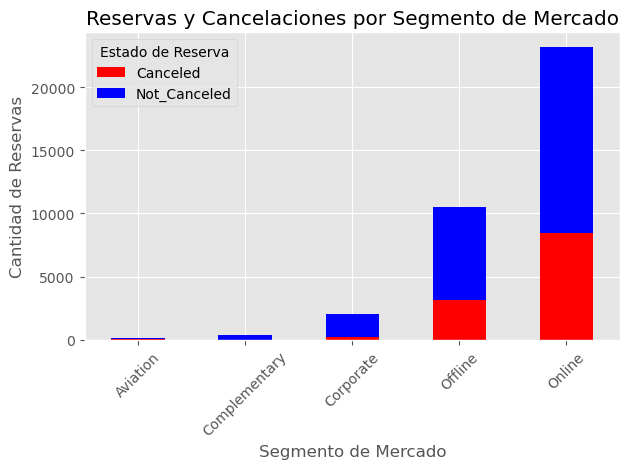

In [24]:
# Agrupar por segmento de mercado y estado de reserva, contar ocurrencias
market_segment_status = df.groupby(['market_segment_type', 'booking_status']).size().unstack()

# Crear gráfico de barras apiladas
plt.figure(figsize=(10, 6))
market_segment_status.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.title('Reservas y Cancelaciones por Segmento de Mercado')
plt.xlabel('Segmento de Mercado')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [25]:
# Create summary table for market segments
market_summary = market_segment_status.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas_No_Canceladas'
}).reset_index()

# Fill NaN values with 0 for Complementary segment
market_summary['Cancelaciones'] = market_summary['Cancelaciones'].fillna(0)

# Calculate total reservations and cancellation percentage
market_summary['Reservas_totales'] = market_summary['Cancelaciones'] + market_summary['Reservas_No_Canceladas']
market_summary['Porcentaje_cancelaciones'] = (market_summary['Cancelaciones'] / market_summary['Reservas_totales'] * 100).round(2)

# Select and rename columns for final display
market_segment_table = market_summary[['market_segment_type', 'Reservas_totales', 'Cancelaciones', 'Porcentaje_cancelaciones']]
market_segment_table = market_segment_table.rename(columns={'market_segment_type': 'Segmento'})

# Display the table
display(market_segment_table)

booking_status,Segmento,Reservas_totales,Cancelaciones,Porcentaje_cancelaciones
0,Aviation,125.0,37.0,29.60
1,Complementary,390.0,0.0,0.00
2,Corporate,2011.0,220.0,10.94
3,Offline,10518.0,3152.0,29.97
4,Online,23194.0,8469.0,36.51


#### Observaciones

**Análisis de Segmentos de Mercado vs Cancelaciones**

1. **Online**: 
    - Mayor volumen de reservas (23,194)
    - Alta tasa de cancelación (36.51%)
    - Principal fuente de pérdidas (84% del total)

2. **Offline**:
    - Segundo en volumen (10,518)
    - Tasa moderada (29.97%)
    - Representa 31% de cancelaciones

3. **Corporate**:
    - Baja tasa (10.94%)
    - Solo 2% de cancelaciones totales
    - Segmento más estable

4. **Complementary**:
    - Cero cancelaciones
    - Reservas garantizadas (ej. promocionales)

**Recomendación prioritaria**: Enfocar estrategias de retención en el segmento Online, que concentra el mayor riesgo de cancelación.

### Clientes con cancelaciones previas

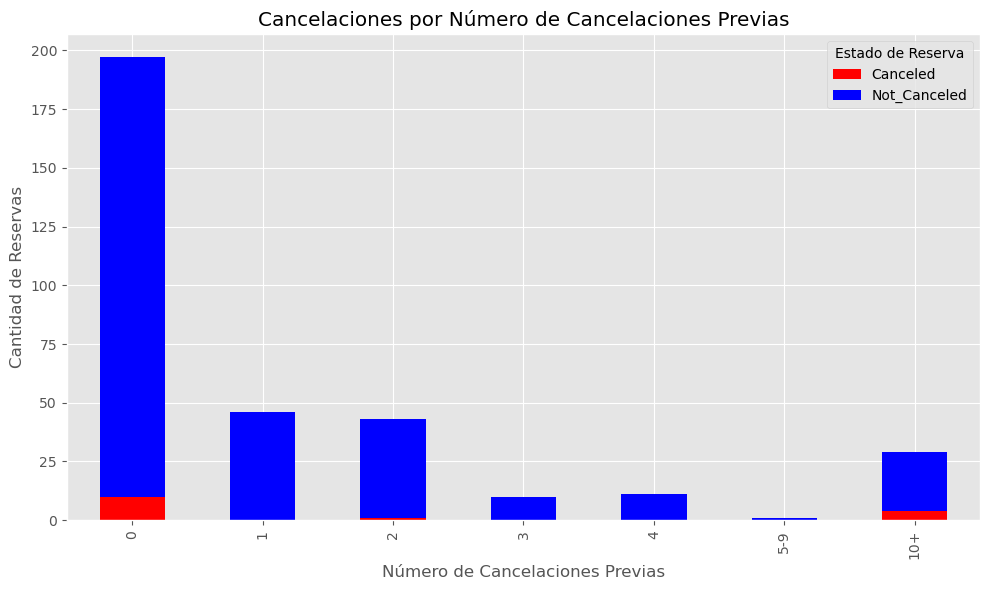

In [26]:
# Create bins for previous cancellations
bins = [0, 1, 2, 3, 4, 5, 10, 20]
labels = ['0', '1', '2', '3', '4', '5-9', '10+']
df['prev_cancels_group'] = pd.cut(df['no_of_previous_cancellations'], bins=bins, labels=labels)

# Group by previous cancellations and booking status
prev_cancel_status = df.groupby(['prev_cancels_group', 'booking_status']).size().unstack()

# Plot stacked bar chart
prev_cancel_status.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'blue'])
plt.title('Cancelaciones por Número de Cancelaciones Previas')
plt.xlabel('Número de Cancelaciones Previas')
plt.ylabel('Cantidad de Reservas')
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [27]:
# Create summary table for previous cancellations
prev_cancel_summary = df.groupby('prev_cancels_group').agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

# Calculate cancellation percentage
prev_cancel_summary['Porcentaje_cancelaciones'] = (prev_cancel_summary['Cancelaciones'] / 
                                                  prev_cancel_summary['Reservas_totales'] * 100).round(2)

# Rename columns for better readability
prev_cancel_summary = prev_cancel_summary.rename(columns={
    'prev_cancels_group': 'Cancelaciones_previas',
    'Reservas_totales': 'Reservas_totales',
    'Cancelaciones': 'Cancelaciones',
    'Porcentaje_cancelaciones': '% Cancelaciones'
})

display(prev_cancel_summary)

,Cancelaciones_previas,Reservas_totales,Cancelaciones,% Cancelaciones
0,0,197,10,5.08
1,1,46,0,0.00
2,2,43,1,2.33
3,3,10,0,0.00
4,4,11,0,0.00
5,5-9,1,0,0.00
6,10+,29,4,13.79


#### Observaciones 

**Análisis de la relación entre cancelaciones y cancelaciones previas**

1. **Patrón general**:
    - Clientes con 0 cancelaciones previas: 5.08% tasa de cancelación
    - Clientes con 10+ cancelaciones previas: 13.79% tasa de cancelación
    - Incremento notable en probabilidad de cancelación según historial

2. **Segmentos críticos**:
    - Clientes con 1-4 cancelaciones previas muestran tasas bajas (0-2.33%)
    - Clientes con 10+ cancelaciones tienen casi 3 veces más probabilidad de cancelar que nuevos clientes

3. **Implicaciones de negocio**:
    - **Políticas diferenciadas**: Considerar requisitos más estrictos para clientes con historial de cancelaciones
    - **Programas de fidelización**: Incentivar buen comportamiento en clientes recurrentes
    - **Sistema de alertas**: Identificar reservas de alto riesgo basado en historial

4. **Recomendaciones**:
    - Implementar depósitos no reembolsables para clientes con múltiples cancelaciones previas
    - Crear categorías de clientes según riesgo de cancelación
    - Ofrecer beneficios por cumplimiento (ej. clientes sin cancelaciones obtienen upgrades)

**Conclusión**: El historial de cancelaciones previas es un predictor significativo del comportamiento futuro, permitiendo estrategias proactivas de gestión de riesgo.

### Precio de la habitación

<Figure size 1200x600 with 0 Axes>

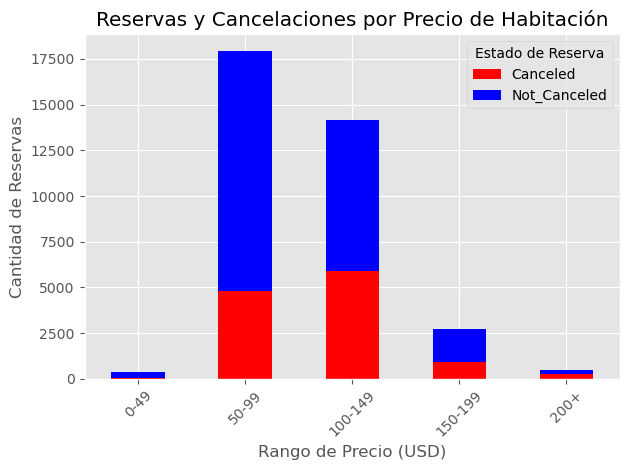

In [28]:
# Create price bins with a single group for prices above 200
price_bins = [0, 50, 100, 150, 200, float('inf')]
price_labels = ['0-49', '50-99', '100-149', '150-199', '200+']

# Categorize room prices
df['price_group'] = pd.cut(df['avg_price_per_room'], bins=price_bins, labels=price_labels)

# Group by price group and booking status
price_status = df.groupby(['price_group', 'booking_status']).size().unstack()

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
price_status.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.title('Reservas y Cancelaciones por Precio de Habitación')
plt.xlabel('Rango de Precio (USD)')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=45)
plt.legend(title='Estado de Reserva')
plt.tight_layout()
plt.show()

In [29]:
# Create summary table for room prices
price_summary = price_status.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas_No_Canceladas'
}).reset_index()

price_summary['Reservas_totales'] = price_summary['Cancelaciones'] + price_summary['Reservas_No_Canceladas']
price_summary['Porcentaje_cancelaciones'] = (price_summary['Cancelaciones'] / price_summary['Reservas_totales'] * 100).round(2)
price_summary['Porcentaje_sobre_total'] = (price_summary['Cancelaciones'] / price_summary['Cancelaciones'].sum() * 100).round(2)

# Rename columns for display
price_table = price_summary[['price_group', 'Reservas_totales', 'Cancelaciones', 
                            'Porcentaje_cancelaciones', 'Porcentaje_sobre_total']]
price_table = price_table.rename(columns={
    'price_group': 'Rango de Precio',
    'Reservas_totales': 'Reservas totales',
    'Cancelaciones': 'Cancelaciones',
    'Porcentaje_cancelaciones': '% Cancelaciones',
    'Porcentaje_sobre_total': '% Sobre total'
})

# Display the table
display(price_table)

booking_status,Rango de Precio,Reservas totales,Cancelaciones,% Cancelaciones,% Sobre total
0,0-49,362,37,10.22,0.31
1,50-99,17952,4803,26.75,40.46
2,100-149,14162,5874,41.48,49.48
3,150-199,2721,915,33.63,7.71
4,200+,496,243,48.99,2.05


#### Observaciones

```markdown
### Análisis de la relación entre precio y cancelaciones

**Hallazgos clave:**
1. **Tasas de cancelación por rango de precio:**
    - **Habitaciones económicas (0-49 USD):** 10.22% de cancelaciones
    - **Habitaciones estándar (50-99 USD):** 26.75% de cancelaciones
    - **Habitaciones premium (100-149 USD):** 41.48% de cancelaciones (pico máximo)
    - **Habitaciones de lujo (150-199 USD):** 33.63% de cancelaciones
    - **Suite (200+ USD):** 48.99% de cancelaciones

2. **Distribución de cancelaciones:**
    - El 49.48% de todas las cancelaciones provienen del rango 100-149 USD
    - Solo el 0.31% de cancelaciones corresponden al rango más económico

3. **Patrones observados:**
    - Relación no lineal: las tasas más altas no están en los precios más elevados
    - Punto crítico en el rango 100-149 USD (41.48% cancelaciones)
    - Segundo pico en suites de 200+ USD (48.99%)

**Recomendaciones estratégicas:**
1. **Segmentación de precios:**
    - Revisar estrategia de precios en el rango 100-149 USD
    - Considerar políticas flexibles para reservas premium

2. **Políticas de cancelación:**
    - Implementar depósitos no reembolsables para suites
    - Ofrecer upgrades gratuitos para reservas en rango crítico que no cancelen

3. **Promociones:**
    - Paquetes todo incluido para habitaciones premium
    - Descuentos por pago anticipado en rangos con alta cancelación

**Impacto económico potencial:**
- Reducir un 10% las cancelaciones en el rango 100-149 USD podría generar ingresos adicionales de ~58,740 USD anuales (considerando precio promedio de 125 USD/noche)
```

### Síntesis de pérdidas y oportunidades

#### Observaciones